# Test models (exponential and q)

## Import library

In [1]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import xarray as xr

## Setting up directory

In [2]:
data_dir = "/home/waves/projects/smap-drydown/data"
datarods_dir = "datarods"
SMAPL3_dir = r"SPL3SMP"
SMAPL4_path = r"SPL4SMGP"
SMAPL4_grid_path = r"SMAPL4SMGP_EASEreference"
PET_dir = r"PET"

import getpass
username = getpass.getuser()
formatted_now = datetime.now().strftime("%Y-%m-%d")
output_dir = rf"/home/waves/projects/smap-drydown/output/fit_models_nb_{username}_{formatted_now}"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Directory '{output_dir}' created.")

Directory '/home/waves/projects/smap-drydown/output/fit_models_nb_raraki_2024-04-03' created.


## Read coordinate information and subset to CONUS

### Define the coordinates

In [3]:
file_path = os.path.join(data_dir, datarods_dir, "coord_info.csv")
coord_info = pd.read_csv(file_path)
file_path = os.path.join(data_dir, datarods_dir, "coord_open_water.csv")
coord_open_water = pd.read_csv(file_path)

min_lon = -125.000000
min_lat = 24.396308
max_lon = -66.934570
max_lat = 49.384358
_conus_subset = coord_info[(coord_info['latitude'] >= min_lat) &
                         (coord_info['latitude'] <= max_lat) &
                         (coord_info['longitude'] >= min_lon) &
                         (coord_info['longitude'] <= max_lon)].copy()

conus_subset = pd.merge(_conus_subset, coord_open_water, on=['EASE_row_index', 'EASE_column_index'], how='left', indicator=True).query('_merge == "left_only"').drop(columns='_merge')
print(len(conus_subset))

9596


## Sample a point

id                   95641.000000
latitude                30.638416
EASE_row_index          99.000000
longitude             -103.257260
EASE_column_index      205.000000
Name: 7858, dtype: float64


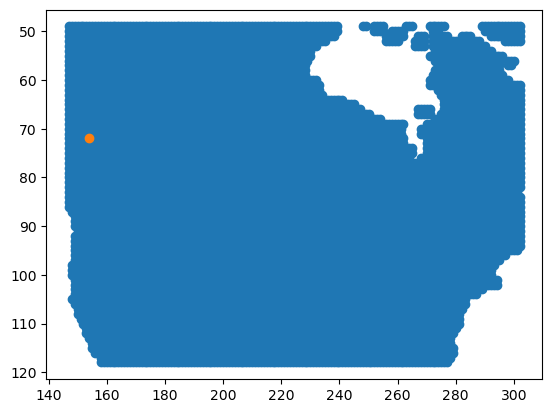

In [4]:
# SPECIFY THE INDEX (0, 9596)
p = 7000

# Plot the location
EASE_row_index = 72 #conus_subset.EASE_row_index.iloc[p].copy()
EASE_column_index = 154 #conus_subset.EASE_column_index.iloc[p].copy()
print(conus_subset.iloc[p])

# Plot 
plt.scatter(conus_subset.EASE_column_index, conus_subset.EASE_row_index)
plt.scatter(EASE_column_index, EASE_row_index)
ax = plt.gca()
ax.invert_yaxis()

## Load datasets

### SMAPL3 Soil mositure data

/home/waves/projects/smap-drydown/data/datarods/SPL3SMP/SPL3SMP_072_154.csv


<Axes: xlabel='time'>

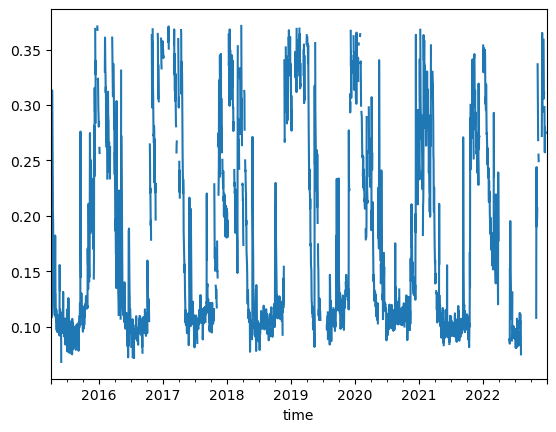

In [6]:
filename = os.path.join(data_dir, datarods_dir, SMAPL3_dir, f"SPL3SMP_{EASE_row_index:03d}_{EASE_column_index:03d}.csv")
print(filename)
df = pd.read_csv(filename)

# Use retrieval flag to quality control the data
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
condition_bad_data_am = (df['Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag'] != 0.0) & (df['Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag'] != 8.0)
condition_bad_data_pm = (df['Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm'] != 0.0) & (df['Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm'] != 8.0)
df.loc[condition_bad_data_am, 'Soil_Moisture_Retrieval_Data_AM_soil_moisture'] = np.nan
df.loc[condition_bad_data_pm, 'Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm'] = np.nan

# There is two different versions of 2015-03-31 data --- remove this 
duplicate_labels = df.index.duplicated(keep=False)
df = df.loc[~df.index.duplicated(keep='first')]

# Resample to regular time interval
df = df.resample('D').asfreq()

# Check if the data is all nan or not
df['Soil_Moisture_Retrieval_Data_AM_soil_moisture'].isna().all()

# Merge the AM and PM soil moisture data into one daily timeseries of data
df['soil_moisture_daily'] = df[['Soil_Moisture_Retrieval_Data_AM_soil_moisture','Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm']].mean(axis=1, skipna=True)
df.soil_moisture_daily.plot()


### SMAPL4 Precipitation data

<Axes: xlabel='time'>

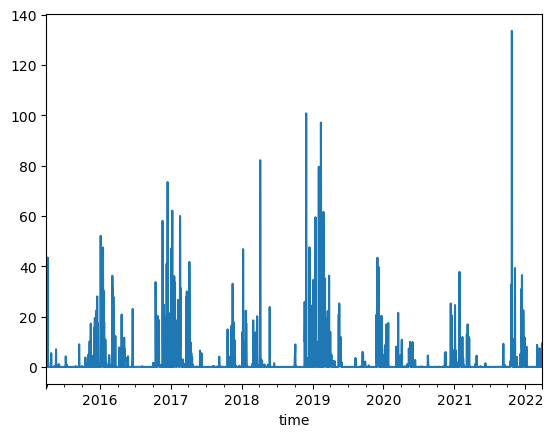

In [8]:
filename = os.path.join(data_dir, datarods_dir, SMAPL4_path, f"SPL4SMGP_{EASE_row_index:03d}_{EASE_column_index:03d}.csv")
df_p = pd.read_csv(filename).drop(columns=['x','y']).rename({'precipitation_total_surface_flux': 'precip'}, axis='columns')
df_p['time'] = pd.to_datetime(df_p['time'])
df_p.set_index('time', inplace=True)

# Convert precipitation from kg/m2/s to mm/day -> 1 kg/m2/s = 86400 mm/day
df_p.precip = df_p.precip * 86400

df_sync = pd.merge(df, df_p, how='inner', left_index=True, right_index=True)

df_sync['noprecip'] = df_sync['precip'] < 2 # < 0.00002 # Check this threshold 
df_sync['precip'].plot()

## Event separation

### Calculate dSdt

In [11]:
# TODO: put this precip mask back once I've got precip data
precip_thresh=2
precip_mask = df_sync['precip'].where(df_sync['precip'] < precip_thresh)
no_sm_record_but_precip_present = df_sync['precip'].where((precip_mask.isnull()) & (df_sync['soil_moisture_daily'].isnull()))

# Allow detecting soil moisture increment even if there is no SM data in between before/after rainfall event
df_sync['sm_for_dS_calc'] = df_sync['soil_moisture_daily'].ffill() 

# Calculate dS
df_sync['dS'] = df_sync['sm_for_dS_calc'].bfill(limit=5).diff().where(df_sync['sm_for_dS_calc'].notnull().shift(periods=+1))

# Drop the dS where  (precipitation is present) && (soil moisture record does not exist)
df_sync['dS'] = df_sync['dS'].where((df_sync['dS'] > -1) & (df_sync['dS'] < 1))

# Calculate dt
non_nulls = df_sync['sm_for_dS_calc'].isnull().cumsum()
nan_length = non_nulls.where(df_sync['sm_for_dS_calc'].notnull()).bfill()+1 - non_nulls +1
df_sync['dt'] = nan_length.where(df_sync['sm_for_dS_calc'].isnull()).fillna(1)

# Calculate dS/dt
df_sync['dSdt'] = df_sync['dS']/df_sync['dt']
df_sync['dSdt'] = df_sync['dSdt'].shift(periods=-1)
df_sync.loc[df_sync['soil_moisture_daily'].shift(-1).isna(), 'dSdt'] = np.nan
df_sync['dSdt'] = df_sync['dSdt'].ffill(limit=5)

### Detect significant peak

Adapt https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2017GL072819


- To avoid noise truncating real drydowns, any positive increment smaller than 5% of the observed range of soil moisture at the site is excluded if it would otherwise truncate a drydown. 
- To avoid noise creating spurious drydowns, identified drydowns were excluded from the analysis when the positive increment preceding the drydown was less than two times the target unbiased root-mean-square difference for SMAP observations (0.08). 
- Of the remaining drydowns, only those that contained more than four SMAP observations were retained.

In [13]:
# Any positive increment smaller than 5% of the observed range of soil moisture at the site is excluded if it would otherwise truncate a drydown. 
max_sm = df_sync.soil_moisture_daily.max()
min_sm = df_sync.soil_moisture_daily.min()
sm_range = max_sm - min_sm
noise_thresh = sm_range * 0.05

# To avoid noise creating spurious drydowns, identified drydowns were excluded from the analysis when the positive increment preceding the drydown was less than two times the target unbiased root-mean-square difference for SMAP observations (0.08).
target_rmsd = 0.04
dSdt_thresh = target_rmsd * 2
print(f"The preceding drydown should be dSdt > {dSdt_thresh:.2f}")
print(f"Drydown torelate the noise dSdt < {noise_thresh:.2f}")

The preceding drydown should be dSdt > 0.08
Drydown torelate the noise dSdt < 0.02


In [15]:
negative_increments = df_sync.dSdt < 0

# To avoid noise creating spurious drydowns, identified drydowns were excluded from the analysis when the positive increment preceding the drydown was less than two times the target unbiased root-mean-square difference for SMAP observations (0.08).
positive_increments = df_sync.dSdt > dSdt_thresh

In [18]:
# TODO: NOT lose drydown starting after NaN

# Negative dSdt preceded with positive dSdt
df_sync['event_start'] = negative_increments.values & np.concatenate(([False], positive_increments[:-1]))
df_sync['event_start'][df_sync['event_start']].index

DatetimeIndex(['2015-04-08', '2015-09-17', '2015-12-04', '2016-03-16',
               '2016-04-10', '2016-04-24', '2016-05-07', '2016-10-17',
               '2017-03-27', '2017-05-31', '2017-06-08', '2017-09-07',
               '2017-10-20', '2017-11-21', '2018-01-10', '2018-03-14',
               '2018-03-23', '2018-04-09', '2018-05-26', '2018-11-24',
               '2018-12-02', '2019-05-16', '2019-05-19', '2019-09-19',
               '2019-09-30', '2019-11-27', '2019-12-04', '2020-03-09',
               '2020-03-20', '2020-04-05', '2020-05-18', '2020-05-31',
               '2020-12-14', '2020-12-26', '2021-01-05', '2021-01-27',
               '2021-03-07', '2021-04-26', '2021-09-10', '2021-10-20',
               '2021-12-07', '2021-12-18', '2022-03-04', '2022-03-16',
               '2022-03-29'],
              dtype='datetime64[ns]', name='time', freq=None)

### Adjust the event start where previous data is nan

In [19]:
event_start_idx = df_sync['event_start'][df_sync['event_start']].index
for i, event_start_date in enumerate(event_start_idx):
    for j in range(0,6): # Look back up to 5 timesteps to seek for sm value which is not nan, or start of the precip event
        current_date = event_start_date - pd.Timedelta(days=j)

        # If rainfall exceeds threshold, stop there
        if (df_sync.loc[current_date].precip > precip_thresh):
            # If sm value is NOT nap.nan, stop there 
            if not np.isnan(df_sync.loc[current_date].soil_moisture_daily):  # Check if sm value is np.nan
                update_date = current_date
            else: 
                update_date = event_start_date
            break
        
        # If dS > 0, stop there 
        if df_sync.loc[current_date].dS > 0:
                update_date = event_start_date
                break

        # SM value is not NaN, update to that value 
        if ((i - j) >= 0) or (not np.isnan(df_sync.loc[current_date].soil_moisture_daily)):
            update_date = current_date
            break

    df_sync.loc[event_start_date, 'event_start']  = False
    df_sync.loc[update_date, 'event_start'] = True
    print(f"{event_start_date} replaced at {update_date}")

2015-04-08 00:00:00 replaced at 2015-04-08 00:00:00
2015-09-17 00:00:00 replaced at 2015-09-17 00:00:00
2015-12-04 00:00:00 replaced at 2015-12-04 00:00:00
2016-03-16 00:00:00 replaced at 2016-03-16 00:00:00
2016-04-10 00:00:00 replaced at 2016-04-10 00:00:00
2016-04-24 00:00:00 replaced at 2016-04-24 00:00:00
2016-05-07 00:00:00 replaced at 2016-05-07 00:00:00
2016-10-17 00:00:00 replaced at 2016-10-17 00:00:00
2017-03-27 00:00:00 replaced at 2017-03-27 00:00:00
2017-05-31 00:00:00 replaced at 2017-05-31 00:00:00
2017-06-08 00:00:00 replaced at 2017-06-08 00:00:00
2017-09-07 00:00:00 replaced at 2017-09-07 00:00:00
2017-10-20 00:00:00 replaced at 2017-10-20 00:00:00
2017-11-21 00:00:00 replaced at 2017-11-21 00:00:00
2018-01-10 00:00:00 replaced at 2018-01-10 00:00:00
2018-03-14 00:00:00 replaced at 2018-03-14 00:00:00
2018-03-23 00:00:00 replaced at 2018-03-23 00:00:00
2018-04-09 00:00:00 replaced at 2018-04-09 00:00:00
2018-05-26 00:00:00 replaced at 2018-05-26 00:00:00
2018-11-24 0

In [20]:
event_start_idx = np.isnan(df_sync["soil_moisture_daily"][df_sync['event_start']]).index
event_start_idx

DatetimeIndex(['2015-04-08', '2015-09-17', '2015-12-04', '2016-03-16',
               '2016-04-10', '2016-04-24', '2016-05-07', '2016-10-17',
               '2017-03-27', '2017-05-31', '2017-06-08', '2017-09-07',
               '2017-10-20', '2017-11-21', '2018-01-10', '2018-03-14',
               '2018-03-23', '2018-04-09', '2018-05-26', '2018-11-24',
               '2018-12-02', '2019-05-16', '2019-05-19', '2019-09-19',
               '2019-09-30', '2019-11-27', '2019-12-04', '2020-03-09',
               '2020-03-20', '2020-04-05', '2020-05-18', '2020-05-31',
               '2020-12-14', '2020-12-26', '2021-01-05', '2021-01-27',
               '2021-03-07', '2021-04-26', '2021-09-10', '2021-10-20',
               '2021-12-07', '2021-12-18', '2022-03-04', '2022-03-16',
               '2022-03-29'],
              dtype='datetime64[ns]', name='time', freq=None)

In [21]:
event_start_idx_2 = pd.isna(df_sync["soil_moisture_daily"][df_sync['event_start']]).index
for i, event_start_date in enumerate(event_start_idx_2):
    update_date = event_start_date
    for j in range(0,6): # Look back up to 5 timesteps to seek for sm value which is not nan, or start of the precip event
        current_date = event_start_date + pd.Timedelta(days=j)
        print(current_date)
        # If rainfall exceeds threshold, stop there
        # SM value is not NaN, update to that value 
        if ((i + j) >= len(df_sync)) or (not pd.isna(df_sync.loc[current_date].soil_moisture_daily)):
            update_date = current_date
            break

    df_sync.loc[event_start_date, 'event_start']  = False
    df_sync.loc[update_date, 'event_start'] = True
    print(f"{event_start_date} replaced at {update_date}")

2015-04-08 00:00:00
2015-04-08 00:00:00 replaced at 2015-04-08 00:00:00
2015-09-17 00:00:00
2015-09-17 00:00:00 replaced at 2015-09-17 00:00:00
2015-12-04 00:00:00
2015-12-04 00:00:00 replaced at 2015-12-04 00:00:00
2016-03-16 00:00:00
2016-03-16 00:00:00 replaced at 2016-03-16 00:00:00
2016-04-10 00:00:00
2016-04-10 00:00:00 replaced at 2016-04-10 00:00:00
2016-04-24 00:00:00
2016-04-24 00:00:00 replaced at 2016-04-24 00:00:00
2016-05-07 00:00:00
2016-05-08 00:00:00
2016-05-07 00:00:00 replaced at 2016-05-08 00:00:00
2016-10-17 00:00:00
2016-10-17 00:00:00 replaced at 2016-10-17 00:00:00
2017-03-27 00:00:00
2017-03-28 00:00:00
2017-03-27 00:00:00 replaced at 2017-03-28 00:00:00
2017-05-31 00:00:00
2017-05-31 00:00:00 replaced at 2017-05-31 00:00:00
2017-06-08 00:00:00
2017-06-08 00:00:00 replaced at 2017-06-08 00:00:00
2017-09-07 00:00:00
2017-09-07 00:00:00 replaced at 2017-09-07 00:00:00
2017-10-20 00:00:00
2017-10-20 00:00:00 replaced at 2017-10-20 00:00:00
2017-11-21 00:00:00
2017

In [22]:
df_sync["event_start"][df_sync["event_start"]].index

DatetimeIndex(['2015-04-08', '2015-09-17', '2015-12-04', '2016-03-16',
               '2016-04-10', '2016-04-24', '2016-05-08', '2016-10-17',
               '2017-03-28', '2017-05-31', '2017-06-08', '2017-09-07',
               '2017-10-20', '2017-11-21', '2018-01-10', '2018-03-14',
               '2018-03-23', '2018-04-09', '2018-05-26', '2018-11-24',
               '2018-12-02', '2019-05-16', '2019-05-19', '2019-09-19',
               '2019-09-30', '2019-11-27', '2019-12-04', '2020-03-10',
               '2020-03-20', '2020-04-05', '2020-05-18', '2020-05-31',
               '2020-12-14', '2020-12-26', '2021-01-05', '2021-01-27',
               '2021-03-07', '2021-04-26', '2021-09-10', '2021-10-20',
               '2021-12-07', '2021-12-19', '2022-03-04', '2022-03-16',
               '2022-03-29'],
              dtype='datetime64[ns]', name='time', freq=None)

### Iterate through each row to find event end

In [23]:
noise_thresh

0.015151038200000001

In [24]:
event_start_idx = df_sync['event_start'][df_sync['event_start']].index

In [39]:
precip_thresh = 2
df_sync['event_end'] = np.zeros(len(df_sync), dtype=bool)
event_start_idx = df_sync['event_start'][df_sync['event_start']].index[:-1]
for i, event_start_date in enumerate(event_start_idx):
    print(f"processing {event_start_date}")
    for j in range(1, len(df_sync)):
        current_date = event_start_date + pd.Timedelta(days=j)
        
        if (i+j) > len(df_sync):
            print("end of the loop")
            break

        if np.isnan(df_sync.loc[current_date].soil_moisture_daily):
            continue

        if (df_sync.loc[current_date].dSdt >= noise_thresh) or (df_sync.loc[current_date].precip > precip_thresh): 
            # Any positive increment smaller than 5% of the observed range of soil moisture at the site is excluded (if there is not precipitation) if it would otherwise truncate a drydown. 
            df_sync.loc[current_date, 'event_end'] = True
            print(f"end reached at {current_date}")
            break  
        else:
            continue

# create a new column for event_end
df_sync['dSdt(t-1)'] = df_sync.dSdt.shift(+1)

processing 2015-04-08 00:00:00
end reached at 2015-04-23 00:00:00
processing 2015-09-17 00:00:00
end reached at 2015-10-01 00:00:00
processing 2015-12-04 00:00:00
end reached at 2015-12-06 00:00:00
processing 2016-03-16 00:00:00
end reached at 2016-03-20 00:00:00
processing 2016-04-10 00:00:00
end reached at 2016-04-14 00:00:00
processing 2016-04-24 00:00:00
end reached at 2016-05-03 00:00:00
processing 2016-05-08 00:00:00
end reached at 2016-05-20 00:00:00
processing 2016-10-17 00:00:00
end reached at 2016-10-24 00:00:00
processing 2017-03-28 00:00:00
end reached at 2017-04-04 00:00:00
processing 2017-05-31 00:00:00
end reached at 2017-06-07 00:00:00
processing 2017-06-08 00:00:00
end reached at 2017-06-19 00:00:00
processing 2017-09-07 00:00:00
end reached at 2017-10-20 00:00:00
processing 2017-10-20 00:00:00
end reached at 2017-11-03 00:00:00
processing 2017-11-21 00:00:00
end reached at 2017-11-26 00:00:00
processing 2018-01-10 00:00:00
end reached at 2018-01-15 00:00:00
processing

### Get normalized SM

In [43]:
df_sync['normalized_S'] = (df_sync.soil_moisture_daily - min_sm)/(max_sm - min_sm)

### Plot

(18170.0, 18535.0)

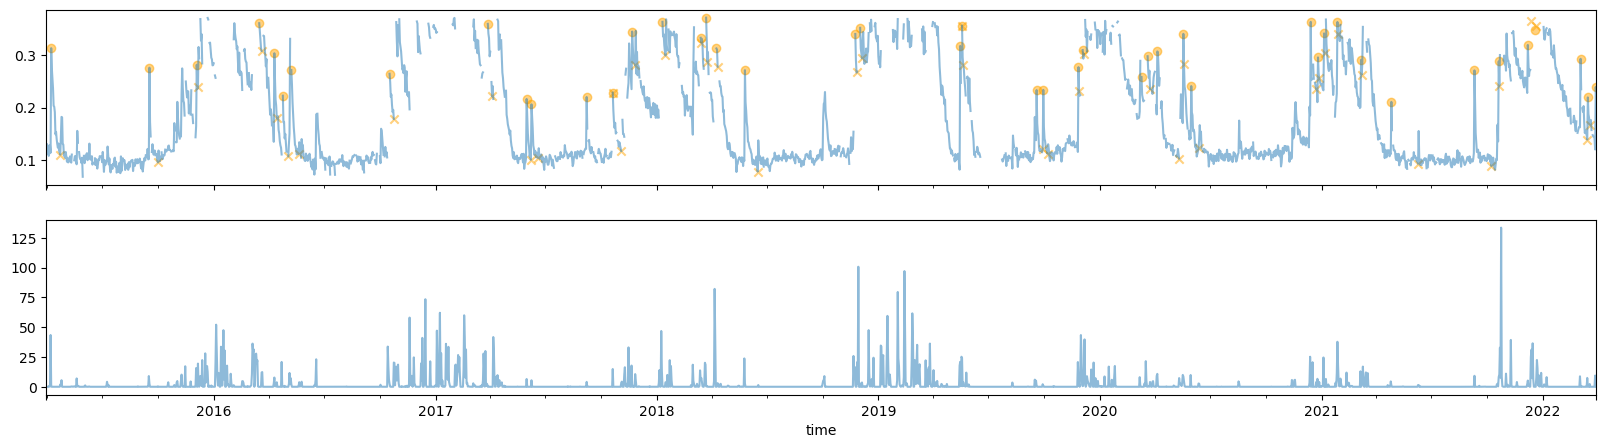

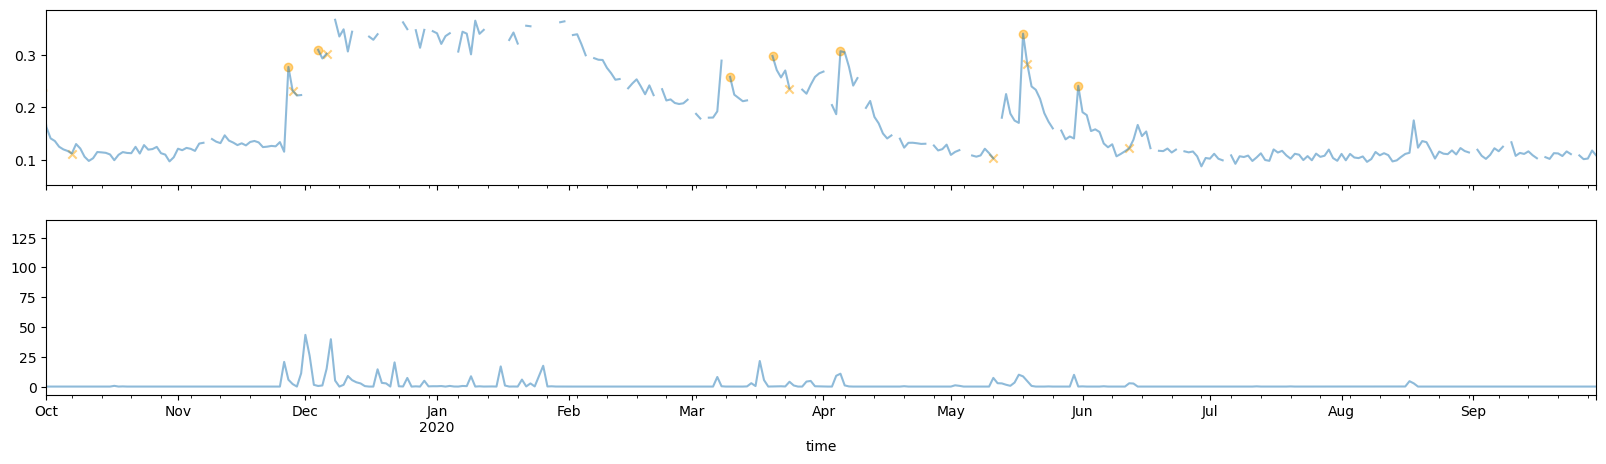

In [44]:
fig, (ax11, ax12) = plt.subplots(2,1, figsize=(20, 5), sharex=True)
df_sync.soil_moisture_daily.plot(ax=ax11, alpha=0.5)
ax11.scatter(df_sync.index[df_sync['event_start']], df_sync['soil_moisture_daily'][df_sync['event_start']], color='orange', alpha=0.5)
ax11.scatter(df_sync.index[df_sync['event_end']], df_sync['soil_moisture_daily'][df_sync['event_end']], color='orange', marker='x', alpha=0.5)
ax11.set_xlim('2019', '2020')
df_sync.precip.plot(ax=ax12, alpha=0.5)
fig.savefig(os.path.join(output_dir, f'pt_{EASE_row_index:03d}_{EASE_column_index:03d}_timeseries.png'))

fig2, (ax21, ax22) = plt.subplots(2,1, figsize=(20, 5), sharex=True)
df_sync.soil_moisture_daily.plot(ax=ax21, alpha=0.5)
ax21.scatter(df_sync.soil_moisture_daily[df_sync['event_start']].index, df_sync.soil_moisture_daily[df_sync['event_start']].values, color='orange', alpha=0.5)
ax21.scatter(df_sync.soil_moisture_daily[df_sync['event_end']].index, df_sync.soil_moisture_daily[df_sync['event_end']].values, color='orange', marker='x', alpha=0.5)
df_sync.precip.plot(ax=ax22, alpha=0.5)

ax22.set_xlim([datetime(2019, 10, 1), datetime(2020, 9, 30)])

### Separate into events

In [47]:
start_indices = df_sync[df_sync['event_start']].index
end_indices = df_sync[df_sync['event_end']].index

# Create a new DataFrame with each row containing a list of soil moisture values between each pair of event_start and event_end
event_data = [{'event_start': start_index, 
               'event_end': end_index, 
               'soil_moisture_daily': list(df_sync.loc[start_index:end_index, 'soil_moisture_daily'].values),
               'normalized_S': list(df_sync.loc[start_index:end_index, 'normalized_S'].values),
               'delta_theta': df_sync.loc[start_index, 'dSdt(t-1)'],
               } 
               for start_index, end_index in zip(start_indices, end_indices)]
event_df = pd.DataFrame(event_data)

min_consective_days = 5
event_df_long = event_df[event_df['soil_moisture_daily'].apply(lambda x: pd.notna(x).sum()) >= min_consective_days].copy()
event_df_long = event_df_long.reset_index(drop=True)
event_df_long

,event_start,event_end,soil_moisture_daily,normalized_S,delta_theta
0,2015-04-08,2015-04-23,"[0.31318346, 0.275290015, 0.25687596, 0.236819...","[0.8081865109415408, 0.6831342059450421, 0.622...",0.199154
1,2015-09-17,2015-10-01,"[0.2760191, 0.17227228, 0.14501567, nan, 0.115...","[0.6855402621848053, 0.34316497862172907, 0.25...",0.173977
2,2016-03-16,2016-03-20,"[0.3607781, 0.3466225, 0.3291855, 0.3135483, 0...","[0.9652537672302879, 0.9185388166997032, 0.860...",0.098935
3,2016-04-10,2016-04-14,"[0.30355594, 0.254857445, 0.21518575, 0.203677...","[0.7764146948028949, 0.6157046023420363, 0.484...",0.168689
4,2016-04-24,2016-05-03,"[0.22268979, 0.17211865, 0.17299919, 0.1414198...","[0.509547999159556, 0.3426579836621362, 0.3455...",0.111997
5,2016-05-08,2016-05-20,"[0.27150503, 0.2444901, 0.20926307, 0.18477876...","[0.6706433622482716, 0.5814912868479205, 0.465...",-0.059529
6,2016-10-17,2016-10-24,"[0.26443505, 0.24839006, 0.22065724, 0.2249318...","[0.6473116937953467, 0.5943615599886746, 0.502...",0.159293
7,2017-03-28,2017-04-04,"[0.35951376, 0.340736535, 0.33241096, 0.297711...","[0.9610813138864637, 0.8991145207461757, 0.871...",-0.011451
8,2017-05-31,2017-06-07,"[0.21642359, 0.18280343, 0.15117903, 0.1348332...","[0.48886888820595814, 0.3779188676324504, 0.27...",0.113048
9,2017-06-08,2017-06-19,"[0.20626253, 0.18218284, 0.1610876, 0.12786897...","[0.455336334641411, 0.37587085616350707, 0.306...",0.105728


## Fit models to drydown curve

### Calculate tau & q

In [48]:
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.optimize import minimize

### Expontnetial model

In [49]:
# Function for exponential model
def exp_model(t, delta_theta, theta_w, tau):
    return delta_theta * np.exp(-t/tau) + theta_w

def neg_log_likelihood(params, t, y):
    delta_theta, theta_w, tau, sigma = params
    y_hat = exp_model(t, delta_theta, theta_w, tau)
    residuals = y - y_hat
    ssr = np.sum(residuals ** 2)
    n = len(y)
    sigma2 = ssr / n
    ll = -(n / 2) * np.log(2 * np.pi * sigma2) - (1 / (2 * sigma2)) * ssr
    return -ll

In [50]:
# Fit exponential model to each drydown event
opt_model = 'OLSE'
drydown_params = []

for index, row in event_df_long.iterrows():
    
    # Read the data
    start_date = row['event_start']
    end_date = row['event_end']
    delta_theta = row['delta_theta']
    soil_moisture_subset = np.asarray(row['normalized_S'])
    t = np.arange(0, len(soil_moisture_subset),1)
    soil_moisture_range = np.nanmax(soil_moisture_subset) - np.nanmin(soil_moisture_subset)
    soil_moisture_subset_min = np.nanmin(soil_moisture_subset)
    soil_moisture_subset_max = np.nanmax(soil_moisture_subset)
    x = t[~np.isnan(soil_moisture_subset)]
    y = soil_moisture_subset[~np.isnan(soil_moisture_subset)]

    # Define the bounds
    # exp_model(t, delta_theta, theta_w, tau):
    bounds  = [(0, min_sm, 0), (2*soil_moisture_range, soil_moisture_subset_min, np.inf)]
    p0      = [0.5*soil_moisture_range, (soil_moisture_subset_min+min_sm)/2, 1]
    try: 
        # Fit the data
        popt, pcov = curve_fit(f=exp_model, xdata=x, ydata=y, p0=p0, bounds=bounds)
        # popt: Optimal values for the parameters so that the sum of the squared residuals of f(xdata, *popt) - ydata is minimized
        # pcov: The estimated covariance of popt
        
        # Reroduce the analytical solution and calculate the residuals
        y_opt = exp_model(x, *popt)
        residuals = y - y_opt
        ss_res = np.sum(residuals ** 2)
        ss_tot = np.sum((y - np.nanmean(y)) ** 2)
        r_squared = 1 - (ss_res / ss_tot)
        
        # Save
        drydown_params.append({'event_start': start_date, 'event_end': end_date, 'delta_theta': popt[0], 'theta_w': popt[1], 'tau': popt[2], 'r_squared': r_squared, 'opt_drydown': y_opt.tolist()})
        
    except Exception as e:
        print("An error occurred:", e)
        continue

# Convert drydown parameters to DataFrame
drydown_params_df = pd.DataFrame(drydown_params)
drydown_params_df.head()

An error occurred: Each lower bound must be strictly less than each upper bound.
An error occurred: Each lower bound must be strictly less than each upper bound.
An error occurred: Each lower bound must be strictly less than each upper bound.
An error occurred: Each lower bound must be strictly less than each upper bound.
An error occurred: Each lower bound must be strictly less than each upper bound.


,event_start,event_end,delta_theta,theta_w,tau,r_squared,opt_drydown
0,2015-04-08,2015-04-23,0.742547,0.068286,6.413322,0.986929,"[0.8108336636403076, 0.7036268777079007, 0.611..."
1,2015-09-17,2015-10-01,0.553642,0.089920,1.882470,0.893611,"[0.6435626954012007, 0.41540060267194057, 0.28..."
2,2016-03-16,2016-03-20,0.348393,0.620861,5.350081,0.989461,"[0.9692534641581199, 0.9098580103820784, 0.860..."
3,2016-04-10,2016-04-14,0.504814,0.271593,2.532197,0.992422,"[0.7764067615781443, 0.6117052719314777, 0.500..."
4,2016-04-24,2016-05-03,0.379712,0.106226,3.558437,0.935026,"[0.4859380726651642, 0.3929130989507944, 0.322..."


In [51]:
# This is also my attempt to use the minnimize function in 
    # # opt_model = 'MLE'
    # if opt_model == "MLE":
    #     bounds  = ((0, 2*soil_moisture_range), (min_sm_values_at_the_pt, soil_moisture_subset_min), (0, np.inf), (0, np.inf))
    #     p0      = [0.5*soil_moisture_subset_max, (min_sm_values_at_the_pt+soil_moisture_subset_min)/2, 1, 0.1]
    #     res = minimize(neg_log_likelihood, p0, args=(t[~np.isnan(soil_moisture_subset)], soil_moisture_subset[~np.isnan(soil_moisture_subset)]), bounds=bounds, method='L-BFGS-B')
    #     popt = res.x
    #     if res.success and res.fun < 0:
    #         drydown_params.append({'event_start': start_date, 'event_end': end_date, 'delta_theta': popt[0], 'theta_w': popt[1], 'tau': popt[2]})

In [52]:
event_df_with_curvefit = pd.merge(event_df_long, drydown_params_df.drop(columns='delta_theta'), on=['event_start', 'event_end'], how='outer')
event_df_with_curvefit.head()

,event_start,event_end,soil_moisture_daily,normalized_S,delta_theta,theta_w,tau,r_squared,opt_drydown
0,2015-04-08,2015-04-23,"[0.31318346, 0.275290015, 0.25687596, 0.236819...","[0.8081865109415408, 0.6831342059450421, 0.622...",0.199154,0.068286,6.413322,0.986929,"[0.8108336636403076, 0.7036268777079007, 0.611..."
1,2015-09-17,2015-10-01,"[0.2760191, 0.17227228, 0.14501567, nan, 0.115...","[0.6855402621848053, 0.34316497862172907, 0.25...",0.173977,0.089920,1.882470,0.893611,"[0.6435626954012007, 0.41540060267194057, 0.28..."
2,2016-03-16,2016-03-20,"[0.3607781, 0.3466225, 0.3291855, 0.3135483, 0...","[0.9652537672302879, 0.9185388166997032, 0.860...",0.098935,0.620861,5.350081,0.989461,"[0.9692534641581199, 0.9098580103820784, 0.860..."
3,2016-04-10,2016-04-14,"[0.30355594, 0.254857445, 0.21518575, 0.203677...","[0.7764146948028949, 0.6157046023420363, 0.484...",0.168689,0.271593,2.532197,0.992422,"[0.7764067615781443, 0.6117052719314777, 0.500..."
4,2016-04-24,2016-05-03,"[0.22268979, 0.17211865, 0.17299919, 0.1414198...","[0.509547999159556, 0.3426579836621362, 0.3455...",0.111997,0.106226,3.558437,0.935026,"[0.4859380726651642, 0.3929130989507944, 0.322..."


### q model

In [53]:
def q_model(t, k, q, delta_theta, theta_star, theta_w):

    s0 = (delta_theta - theta_w)**(1-q)

    a = (1 - q) / ( ( theta_star - theta_w ) ** q )

    return (- k * a * t + s0 ) ** (1/(1-q)) + theta_w

In [54]:
drydown_params = []
for index, row in event_df_long.iterrows():
    
    # Read the data
    start_date = row['event_start']
    end_date = row['event_end']
    delta_theta = row['delta_theta']
    soil_moisture_subset = np.asarray(row['normalized_S'])
    PET = 10 #np.average(row['PET']) # TODO: fix this as observed PET after getting the dataset
    t = np.arange(0, len(soil_moisture_subset),1)
    soil_moisture_range = np.nanmax(soil_moisture_subset) - np.nanmin(soil_moisture_subset)
    soil_moisture_subset_min = np.nanmin(soil_moisture_subset)
    soil_moisture_subset_max = np.nanmax(soil_moisture_subset)
    x = t[~np.isnan(soil_moisture_subset)]
    y = soil_moisture_subset[~np.isnan(soil_moisture_subset)]
    
    # Define the bounds
    # q_model(t, k, q, delta_theta, theta_star, theta_w=0)
    # custom_q_model = lambda x, mu: q_model(x, mu, 0.05)
    epsilon = 1.0E-10
    bounds  = [(0., 0., 0., 0., 0), (PET*10, 10, 1., 1., 1.)]
    p0      = [PET, 1. + 1.E-03, soil_moisture_range, 0.5, 1.0E-5]
    
    try: 
        # Fit the model
        popt, pcov = curve_fit(f=q_model, xdata=x, ydata=y, p0=p0, bounds=bounds)
        # popt: Optimal values for the parameters so that the sum of the squared residuals of f(xdata, *popt) - ydata is minimized
        # pcov: The estimated covariance of popt
        
        # Reroduce the analytical solution and calculate the residuals
        y_opt = q_model(x, *popt)
        residuals = y - y_opt
        ss_res = np.sum(residuals ** 2)
        ss_tot = np.sum((y - np.nanmean(y)) ** 2)
        r_squared = 1 - (ss_res / ss_tot)
        
        # Save
        drydown_params.append({'event_start': start_date, 'event_end': end_date, 'q__k': popt[0], 'q__q': popt[1], 'q__delta_theta': popt[2], 'q__theta_star': popt[3], 'q__theta_w': popt[4], 'q__r_squared': r_squared, 'q__opt_drydown': y_opt.tolist()})

    except Exception as e:
        print("An error occurred:", e)
        continue

# Convert drydown parameters to DataFrame
drydown_params_df = pd.DataFrame(drydown_params)
drydown_params_df.head()

/tmp/ipykernel_270708/4022162658.py:7: RuntimeWarning: invalid value encountered in power
  return (- k * a * t + s0 ) ** (1/(1-q)) + theta_w
/tmp/ipykernel_270708/4022162658.py:5: RuntimeWarning: invalid value encountered in scalar power
  a = (1 - q) / ( ( theta_star - theta_w ) ** q )
/tmp/ipykernel_270708/4022162658.py:3: RuntimeWarning: invalid value encountered in scalar power
  s0 = (delta_theta - theta_w)**(1-q)
/tmp/ipykernel_270708/202257241.py:26: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f=q_model, xdata=x, ydata=y, p0=p0, bounds=bounds)


An error occurred: array must not contain infs or NaNs
An error occurred: array must not contain infs or NaNs
An error occurred: array must not contain infs or NaNs
An error occurred: array must not contain infs or NaNs
An error occurred: array must not contain infs or NaNs
An error occurred: array must not contain infs or NaNs


,event_start,event_end,q__k,q__q,q__delta_theta,q__theta_star,q__theta_w,q__r_squared,q__opt_drydown
0,2015-04-08,2015-04-23,0.116751,0.638072,0.797859,0.999378,1.400514e-01,0.988046,"[0.7978593297708791, 0.7040469399117151, 0.619..."
1,2015-09-17,2015-10-01,3.719840,3.112724,0.685799,0.987469,1.201306e-02,0.983509,"[0.6857988256765601, 0.3363313403007568, 0.258..."
2,2016-03-16,2016-03-20,10.000000,1.001000,0.393784,0.500000,3.937842e-01,-52.746611,"[0.39378436669840255, 0.3937842198444179, 0.39..."
3,2016-04-10,2016-04-14,0.364674,2.080967,0.777259,0.997667,9.667101e-11,0.992790,"[0.777258967627719, 0.6090331252727077, 0.5022..."
4,2016-04-24,2016-05-03,0.634030,2.070817,0.498165,0.999363,2.661601e-14,0.942875,"[0.49816513270858614, 0.3837505377097909, 0.31..."


In [55]:
event_df_with_curvefit = pd.merge(event_df_with_curvefit, drydown_params_df, on=['event_start', 'event_end'], how='outer')
event_df_with_curvefit.head()

,event_start,event_end,soil_moisture_daily,normalized_S,delta_theta,theta_w,tau,r_squared,opt_drydown,q__k,q__q,q__delta_theta,q__theta_star,q__theta_w,q__r_squared,q__opt_drydown
0,2015-04-08,2015-04-23,"[0.31318346, 0.275290015, 0.25687596, 0.236819...","[0.8081865109415408, 0.6831342059450421, 0.622...",0.199154,0.068286,6.413322,0.986929,"[0.8108336636403076, 0.7036268777079007, 0.611...",0.116751,0.638072,0.797859,0.999378,1.400514e-01,0.988046,"[0.7978593297708791, 0.7040469399117151, 0.619..."
1,2015-09-17,2015-10-01,"[0.2760191, 0.17227228, 0.14501567, nan, 0.115...","[0.6855402621848053, 0.34316497862172907, 0.25...",0.173977,0.089920,1.882470,0.893611,"[0.6435626954012007, 0.41540060267194057, 0.28...",3.719840,3.112724,0.685799,0.987469,1.201306e-02,0.983509,"[0.6857988256765601, 0.3363313403007568, 0.258..."
2,2016-03-16,2016-03-20,"[0.3607781, 0.3466225, 0.3291855, 0.3135483, 0...","[0.9652537672302879, 0.9185388166997032, 0.860...",0.098935,0.620861,5.350081,0.989461,"[0.9692534641581199, 0.9098580103820784, 0.860...",10.000000,1.001000,0.393784,0.500000,3.937842e-01,-52.746611,"[0.39378436669840255, 0.3937842198444179, 0.39..."
3,2016-04-10,2016-04-14,"[0.30355594, 0.254857445, 0.21518575, 0.203677...","[0.7764146948028949, 0.6157046023420363, 0.484...",0.168689,0.271593,2.532197,0.992422,"[0.7764067615781443, 0.6117052719314777, 0.500...",0.364674,2.080967,0.777259,0.997667,9.667101e-11,0.992790,"[0.777258967627719, 0.6090331252727077, 0.5022..."
4,2016-04-24,2016-05-03,"[0.22268979, 0.17211865, 0.17299919, 0.1414198...","[0.509547999159556, 0.3426579836621362, 0.3455...",0.111997,0.106226,3.558437,0.935026,"[0.4859380726651642, 0.3929130989507944, 0.322...",0.634030,2.070817,0.498165,0.999363,2.661601e-14,0.942875,"[0.49816513270858614, 0.3837505377097909, 0.31..."


### Plot and save

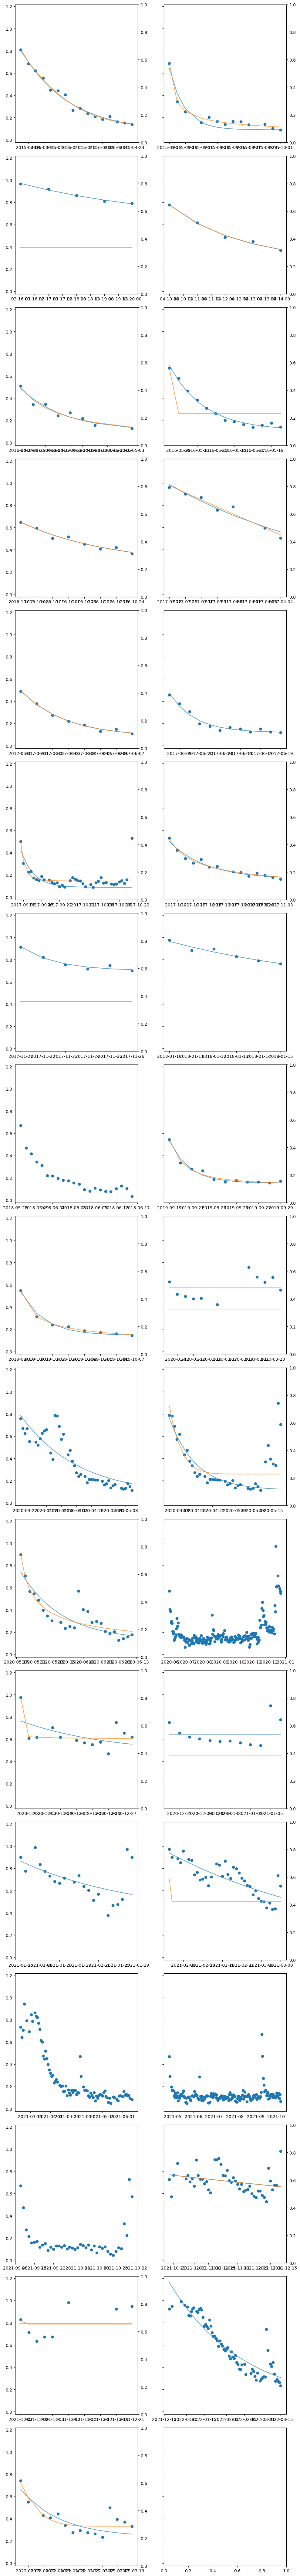

In [57]:
# Convert the event start/end columns to datetime format
event_df_with_curvefit['event_start'] = pd.to_datetime(event_df_long['event_start'])
event_df_with_curvefit['event_end'] = pd.to_datetime(event_df_long['event_end'])

# Determine the number of columns needed for the subplots grid
num_events = len(event_df_with_curvefit)
num_cols = 2
num_rows = int(num_events / num_cols) + int(num_events % num_cols != 0)

# Plot each row of the event DataFrame as a time series
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, sharey=True, figsize=(10, 5*num_rows))
for index, row in event_df_with_curvefit.iterrows():

    x = pd.date_range(start=row['event_start'], end=row['event_end'], freq='D')
    y = np.asarray(row['normalized_S'])
    y_opt = np.asarray(row['opt_drydown'])
    y_opt__q = np.asarray(row['q__opt_drydown'])
    t = np.arange(0, len(row['normalized_S']),1)
    r_squared = row['r_squared']
    q__r_squared = row['q__r_squared']
    q = row['q__q']
    tau = row['tau']
    try:
        ax_row = int(index / num_cols)
        ax_col = index % num_cols
        axes[ax_row, ax_col].scatter(x, y)
        axes[ax_row, ax_col].plot(x[~np.isnan(y)], y_opt, alpha=.7, label=f'expoential: R2={r_squared:.2f}; tau={tau:.2f}')
        axes[ax_row, ax_col].plot(x[~np.isnan(y)], y_opt__q, alpha=.7, label=f'q model: R2={q__r_squared:.2f}; q={q:.5f})')
        ax2 = axes[ax_row, ax_col].twinx()
        ax2.scatter(x, y2, color='orange', alpha=.5)
        axes[ax_row, ax_col].set_title(f'Event {index}')
        axes[ax_row, ax_col].set_xlabel('Date')
        axes[ax_row, ax_col].set_ylabel('Soil Moisture')
        axes[ax_row, ax_col].set_xlim([row['event_start'], row['event_end']])
        axes[ax_row, ax_col].legend()
        ax2.set_ylim([0, 8])
        # Rotate the x tick labels
        axes[ax_row, ax_col].tick_params(axis='x', rotation=45)
    except:
        try:
            ax_row = int(index / num_cols)
            ax_col = index % num_cols
            axes[ax_row].scatter(x, y)
            axes[ax_row].plot(x[~np.isnan(y)], y_opt, alpha=.7, label=f'expoential: R2={r_squared:.2f}; tau={tau:.2f}')
            axes[ax_row].plot(x[~np.isnan(y)], y_opt__q, alpha=.7, label=f'q model: R2={q__r_squared:.2f}; q={q:.5f})')
            ax2 = axes[ax_row].twinx()
            ax2.scatter(x, y2, color='orange', alpha=.5)
            axes[ax_row].set_title(f'Event {index}')
            axes[ax_row].set_xlabel('Date')
            axes[ax_row].set_ylabel('Soil Moisture')
            axes[ax_row].set_xlim([row['event_start'], row['event_end']])
            ax2.set_ylim([0, 8])
            # Rotate the x tick labels
            axes[ax_row].tick_params(axis='x', rotation=45)
        except:
            continue
        continue

fig.tight_layout()
fig.show()
fig.savefig(os.path.join(output_dir, f'pt_{EASE_row_index:03d}_{EASE_column_index:03d}_curvefit.png'))

In [ ]:
event_df_with_curvefit.to_csv(os.path.join(output_dir, f'pt_{EASE_row_index:03d}_{EASE_column_index:03d}_curvefit.csv'), index=True)

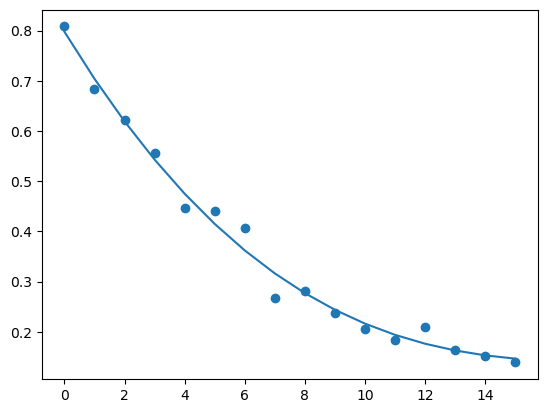

In [58]:
row = event_df_long.iloc[0]

# Read the data
start_date = row['event_start']
end_date = row['event_end']
delta_theta = row['delta_theta']
norm_S = row['normalized_S']
soil_moisture_subset = np.asarray(row['normalized_S'])
PET = 10 #np.average(row['PET']) # TODO: fix this as observed PET after getting the dataset
t = np.arange(0, len(soil_moisture_subset),1)
soil_moisture_range = np.nanmax(soil_moisture_subset) - np.nanmin(soil_moisture_subset)
soil_moisture_subset_min = np.nanmin(soil_moisture_subset)
soil_moisture_subset_max = np.nanmax(soil_moisture_subset)
x = t[~np.isnan(soil_moisture_subset)]
y = soil_moisture_subset[~np.isnan(soil_moisture_subset)]

# Define the bounds
# q_model(t, k, q, delta_theta, theta_star, theta_w=0)
# custom_q_model = lambda x, mu: q_model(x, mu, 0.05)
epsilon = 1.0E-10
bounds  = [(0., 0., 0., 0., 0), (PET*10, 10, 1., 1., 1.)]
p0      = [PET, 1. + 1.E-03, soil_moisture_range, 0.5, 1.0E-5]

# Fit the model
popt, pcov = curve_fit(f=q_model, xdata=x, ydata=y, p0=p0, bounds=bounds)
# popt: Optimal values for the parameters so that the sum of the squared residuals of f(xdata, *popt) - ydata is minimized
# pcov: The estimated covariance of popt

# Reroduce the analytical solution and calculate the residuals
y_opt = q_model(x, *popt)
residuals = y - y_opt
ss_res = np.sum(residuals ** 2)
ss_tot = np.sum((y - np.nanmean(y)) ** 2)
r_squared = 1 - (ss_res / ss_tot)

# Convert drydown parameters to DataFrame
plt.scatter(x, y)
plt.plot(x, y_opt)